In [83]:
!pip install m2cgen


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Principal Notebook. Trata o dataset inteiro

In [84]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

Utils

In [85]:
def cross_val(regressor, X, y, k=10):
    s = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
    results = cross_validate(regressor, X, y, cv=k, scoring=s)
    print(pd.DataFrame(results).mean())


def plot_results(regressor, X_train, y_train, X_test, y_test, y):
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    errors = np.abs(y_pred - y_test)
    errors = errors / max(errors)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, s=200 * errors, c=errors, alpha=0.7, marker='x')
    plt.ylim(0, max(y_pred.max(), y_test.max()))
    plt.xlim(0, max(y_pred.max(), y_test.max()))
    plt.xlabel('Value')
    plt.ylabel('Predicted')

    plt.plot([0, max(y)], [0, max(y)], c='gray')


# def correlation(dataset, threshold):
#     col_corr = set()
#     corr_matrix = dataset.corr()
#     for i in range(len(corr_matrix.columns)):
#         for j in range(i):
#             if abs(corr_matrix.iloc[i, j]) > threshold:
#                 col_name = corr_matrix.columns[i]
#                 col_corr.add(col_name)
#
#     return col_corr


def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                if (corr_matrix.columns[i] not in col_corr) and (corr_matrix.index.tolist()[j] not in col_corr):
                    col_name = corr_matrix.columns[i]
                    col_corr.add(col_name)
    return col_corr

Prepara dataset e remove features

In [86]:
data = pd.read_csv("../dataset/train.csv")

# casos em que essa condição é atendida nunca são selecionados
# data = data[(data['warp_error'] / data['ref_frame_error']) < 0.65]

data.drop([
    'name',
    'cur_ref_count',
    'cur_showable_frame',
    'ref_showable_frame',
    'downsample_level',
    'num_refinements',
    'bit_depth',
    # 'selected'
    # 'ref_frame_error'
    # 'inliers_rate',
    'fast_error',
    'warp_error'
], axis=1, inplace=True)

# Remove os valores constantes (0 variancia)
var_thres = VarianceThreshold(threshold=0)
var_thres.fit(data)

constant_columns = [column for column in data.columns
                    if column not in data.columns[var_thres.get_support()]]

data.drop(constant_columns, axis=1, inplace=True)

df = pd.DataFrame(data, columns=data.columns)
# df = df.sample(frac=1).reset_index(drop=True)
# df = shuffle(df)
df

,distance,num_ref_frames,cq_level,cur_order_hint,ref_ref_count,ref_order_hint,src_width,src_height,src_stride,frame,...,params_4,params_5,alpha,beta,gamma,delta,seg_count,ref_frame_error,selected,inliers_rate
0,1,3,80,3,7,0,1280,720,1600,0,...,0.001133,1.000836,64.0,-64.0,64.0,64.0,282,13583723,1,0.789596
1,1,1,80,2,5,0,1280,720,1600,0,...,0.000509,1.000198,0.0,-64.0,64.0,0.0,312,12353545,1,0.995848
2,1,1,80,4,2,12,1280,720,1600,0,...,-0.000414,0.999844,0.0,0.0,0.0,0.0,340,13120077,1,0.993794
3,1,2,80,4,2,2,1280,720,1600,0,...,0.000859,1.000341,0.0,-64.0,64.0,0.0,331,15298827,1,0.962245
4,1,1,80,5,2,12,1280,720,1600,0,...,-0.000308,0.999848,0.0,0.0,0.0,0.0,335,13184703,1,0.996654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12987,1,1,220,26,2,16,1920,1080,2240,0,...,-0.000620,0.997788,-128.0,64.0,-64.0,-128.0,138,1718698,0,0.270499
12988,1,1,220,26,2,24,1920,1080,2240,0,...,0.000868,1.000068,0.0,-64.0,64.0,0.0,165,1986437,0,0.320349
12989,1,1,220,28,2,16,1920,1080,2240,0,...,-0.000679,0.998326,-128.0,64.0,-64.0,-128.0,157,1716537,0,0.308999
12990,1,1,220,28,2,26,1920,1080,2240,0,...,0.000719,1.001514,128.0,-64.0,64.0,128.0,166,1772204,0,0.344306


Info de balanceamento

selected
1    9330
0    3662
Name: count, dtype: int64

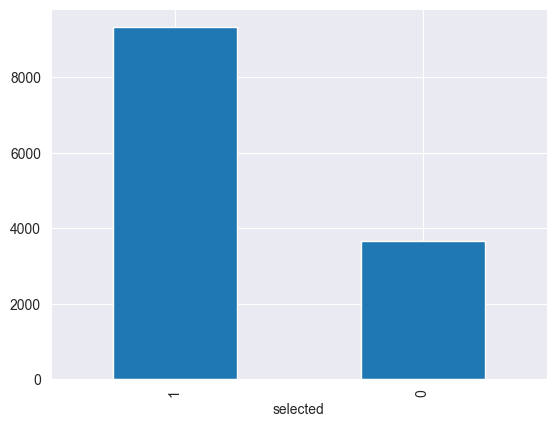

In [87]:
df['selected'].value_counts().plot(kind='bar')
df['selected'].value_counts()

Separa os dados em treino e teste

In [88]:
X = data.drop(['selected'], axis=1)
y = data['selected']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

selected
1    6479
0    2615
Name: count, dtype: int64

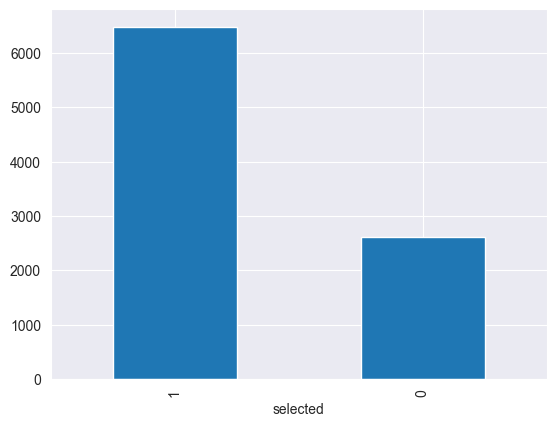

In [89]:
y_train.value_counts().plot(kind='bar')
y_train.value_counts()

Correlação das features

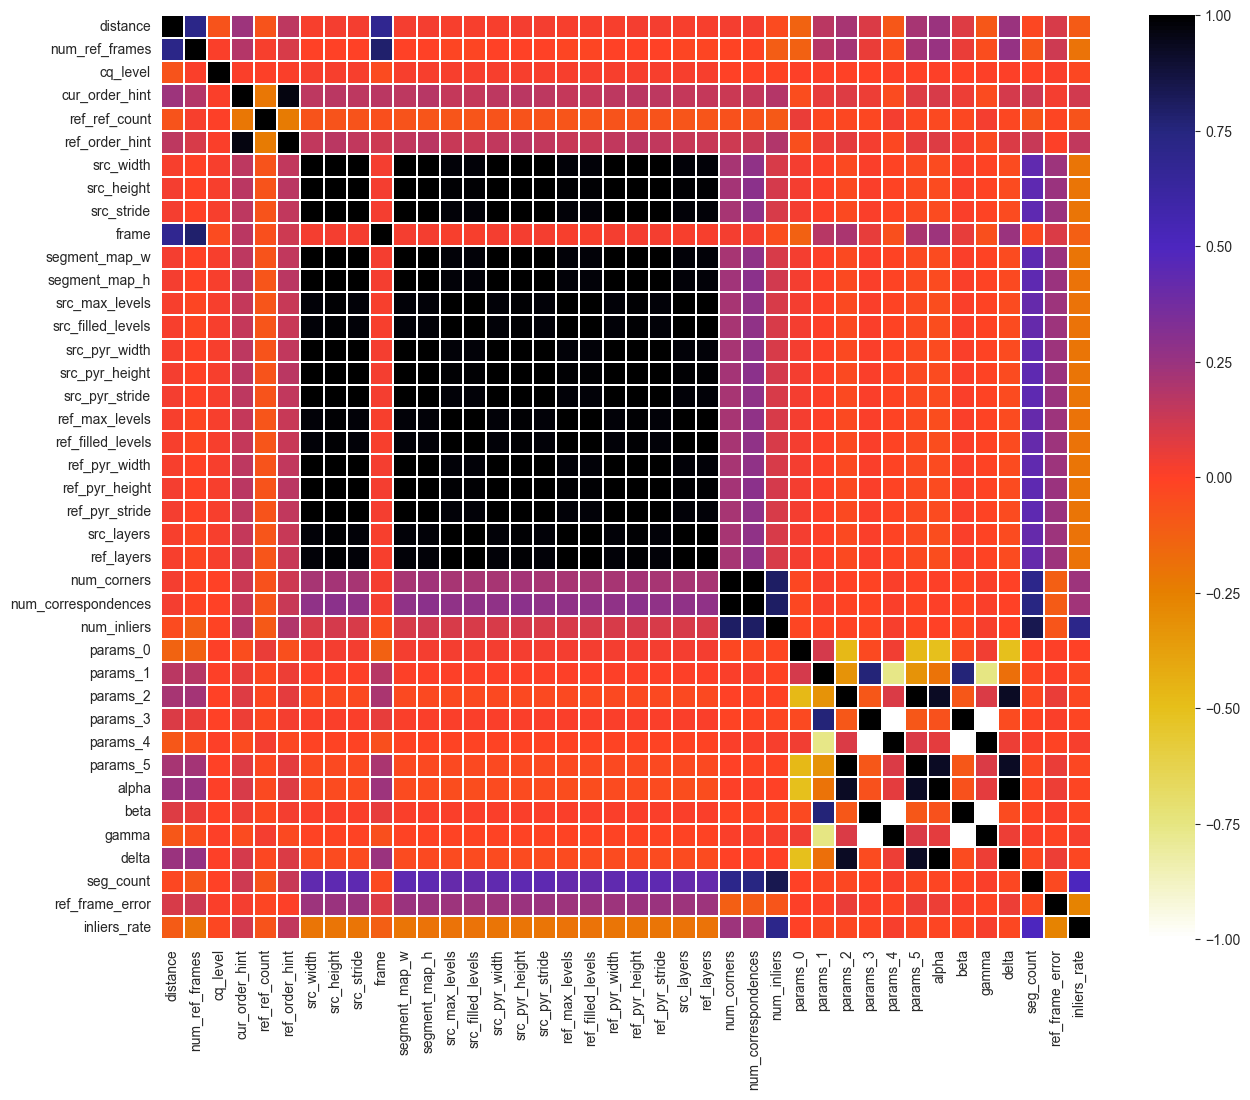

In [90]:
plt.figure(figsize=(15, 12))
sns.heatmap(X_train.corr(), cmap=plt.cm.CMRmap_r, linewidths=.1)
plt.show()

Features correlacionadas em mais de 90%

In [91]:
corr_features = correlation(X_train, 0.8)
corr_features = corr_features.difference(['fast_error', 'ref_frame_error'])
corr_features

{'alpha',
 'beta',
 'delta',
 'gamma',
 'num_correspondences',
 'num_inliers',
 'params_4',
 'params_5',
 'ref_filled_levels',
 'ref_layers',
 'ref_max_levels',
 'ref_order_hint',
 'ref_pyr_height',
 'ref_pyr_stride',
 'ref_pyr_width',
 'segment_map_h',
 'segment_map_w',
 'src_filled_levels',
 'src_height',
 'src_layers',
 'src_max_levels',
 'src_pyr_height',
 'src_pyr_stride',
 'src_pyr_width',
 'src_stride'}

Remove features correlacionadas

In [92]:
X_train = X_train.drop(corr_features, axis=1)
X_test = X_test.drop(corr_features, axis=1)

Normaliza os dados

In [93]:
scaler = StandardScaler().fit(X_train)

X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)
X_normalized = scaler.transform(X.drop(corr_features, axis=1))

Correlação após remoção das features

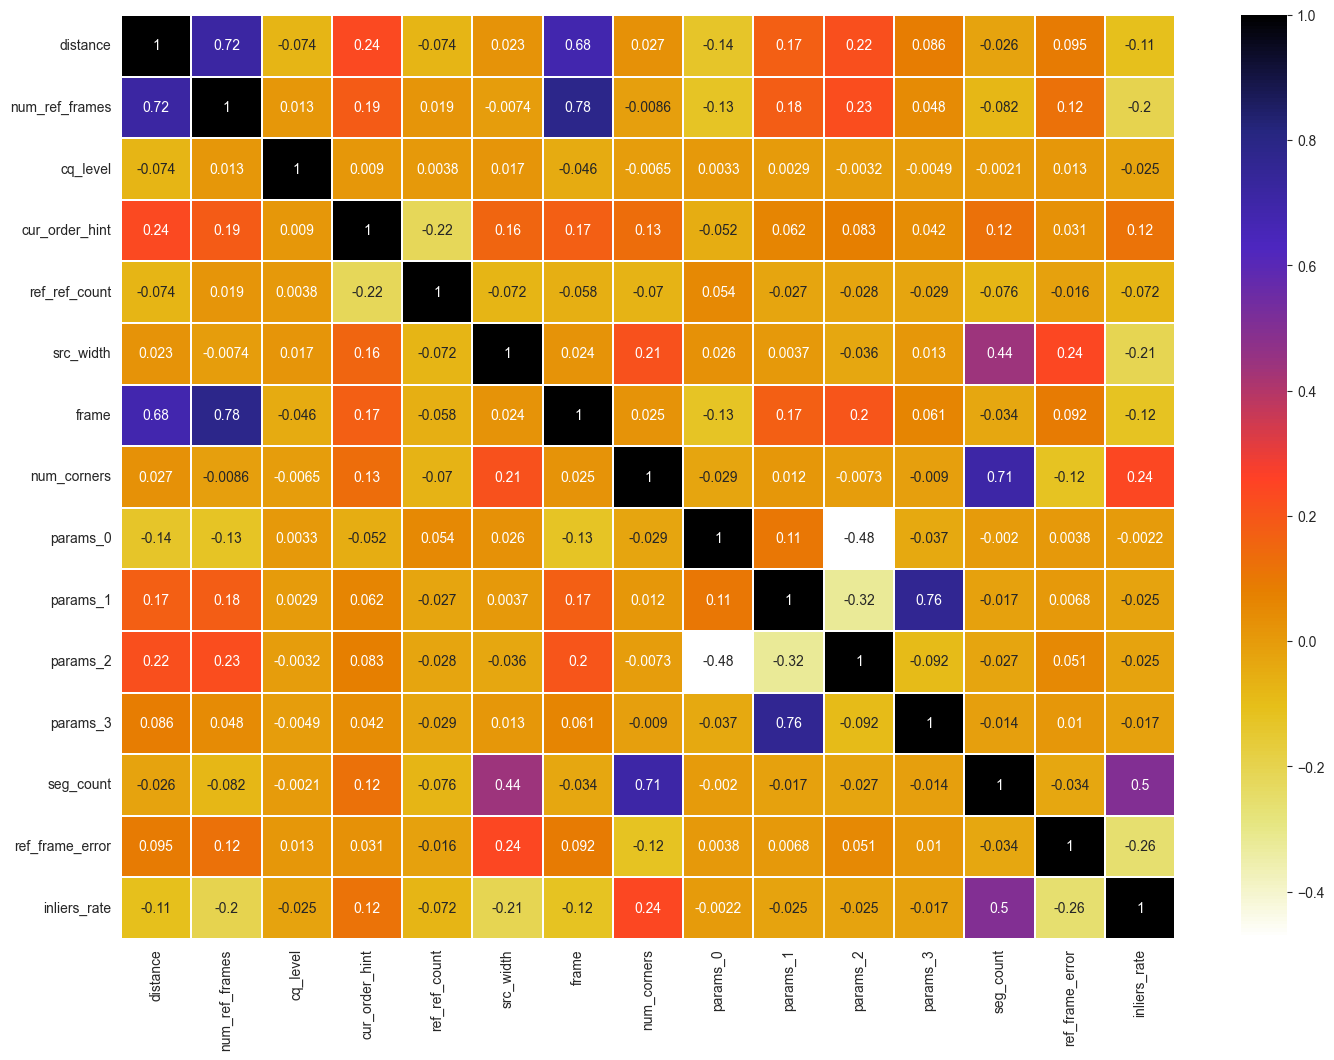

In [94]:
plt.figure(figsize=(17, 12))
sns.heatmap(X_train.corr(), cmap=plt.cm.CMRmap_r, annot=True, linewidths=.1)
plt.show()

Info sobre features mais relevantes

<Axes: >

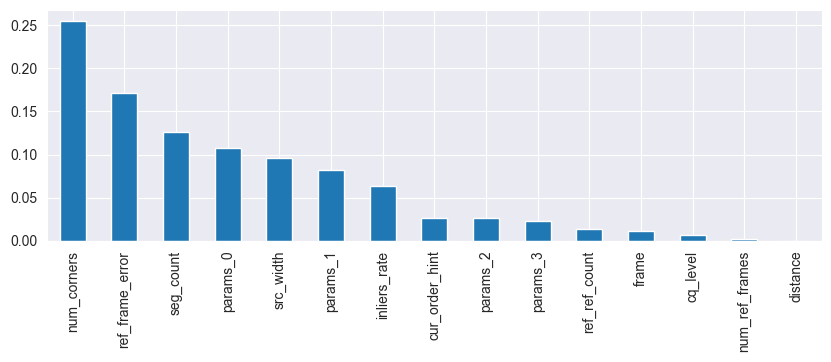

In [95]:
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False).plot.bar(figsize=(10,3))

Lista de features mais importantes baseadas no 1/4-percentil

In [96]:
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=50)
selected_top_columns.fit(X_train, y_train)

select_features = X_train.columns[selected_top_columns.get_support()]

select_features

Index(['src_width', 'num_corners', 'params_0', 'params_1', 'seg_count',
       'ref_frame_error', 'inliers_rate'],
      dtype='object')

In [107]:
from sklearn import tree

dtc = tree.DecisionTreeClassifier(max_depth=len(select_features))

# cross_val(dtc, X[select_features], y, 10)

dtc.fit(X_train[select_features], y_train)
y_pred = dtc.predict(X_test[select_features])

# confusion_matrix(y_test, y_pred)

# f1_score(y_test, y_pred)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1047
           1       0.96      0.96      0.96      2851

    accuracy                           0.95      3898
   macro avg       0.93      0.93      0.93      3898
weighted avg       0.95      0.95      0.95      3898



[Text(0.5, 0.8333333333333334, 'x[5] <= 959841.0\ngini = 0.41\nsamples = 9094\nvalue = [2615.0, 6479.0]'),
 Text(0.25, 0.5, 'x[3] <= 1.077\ngini = 0.31\nsamples = 1355\nvalue = [1095, 260]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.262\nsamples = 1255\nvalue = [1060, 195]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.455\nsamples = 100\nvalue = [35, 65]'),
 Text(0.75, 0.5, 'x[4] <= 47.5\ngini = 0.316\nsamples = 7739\nvalue = [1520, 6219]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.469\nsamples = 814\nvalue = [509, 305]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.249\nsamples = 6925\nvalue = [1011, 5914]')]

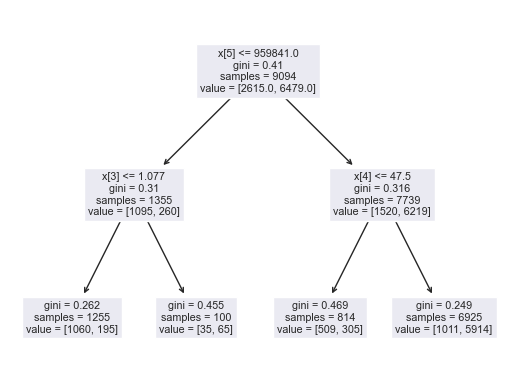

In [104]:
tree.plot_tree(dtc)